In [10]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import learn2learn as l2l
from models import SIREN
from tqdm import tqdm
import os
from icecream import ic

import config

# Assume models are saved in a list of file paths
group_name = "earthquake_default"

ind = 1
model_paths = []
while os.path.exists(config.model_dir + f'{group_name}/eval_{ind}.pth'):
    model_paths.append(config.model_dir + f'{group_name}/eval_{ind}.pth')
    ind += 1
    # if ind >= 270:
    #     break


config.seed_everything(43)

# Function to extract features
def extract_weights(model):
    return torch.cat([p.data.view(-1) for p in model.parameters()])

# Collect all features
all_weights = []

for idx, model_path in enumerate(tqdm(model_paths)):
    # Load the model
    net = SIREN(in_features=3, out_features=1, init_features=64, num_res=5)
    model = l2l.algorithms.MAML(net, lr=0.0005, first_order=True).to(config.device)
    try:
        model.net.load_state_dict(torch.load(model_path))
    except Exception as e:
        try:
            model.load_state_dict(torch.load(model_path))
        except Exception as e:
            net.load_state_dict(torch.load(model_path))
            model = l2l.algorithms.MAML(net, lr=0.0005, first_order=True).to(config.device)
    weights = extract_weights(model.net)
    all_weights.append(weights.cpu().numpy())

# Concatenate features from all models
all_weights = np.asarray(all_weights)

100%|██████████| 598/598 [00:22<00:00, 26.63it/s]


In [11]:
# Apply t-SNE
from io import StringIO
import sys

from sklearn.decomposition import PCA
# pca = PCA(n_components=100)
# all_weights = pca.fit_transform(all_weights)
def compute_tsne(all_weights, perplexity=30, n_iter=3000):
    # catch stdout without print
    tsne = TSNE(n_components=2, random_state=45, perplexity=perplexity, n_iter=n_iter)
    tsne_results = tsne.fit_transform(all_weights)
    return tsne_results

Perplexity: 15


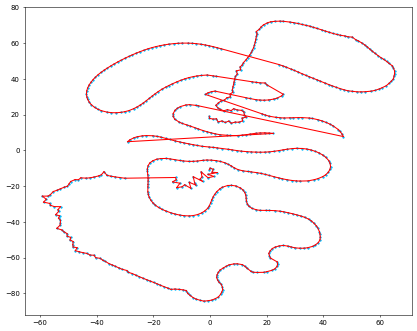

Perplexity: 30


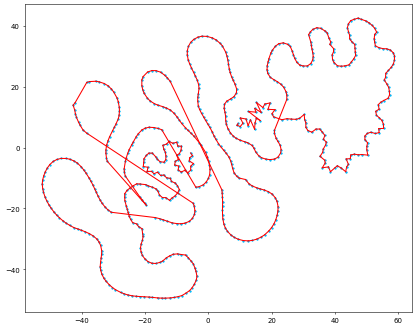

Perplexity: 45


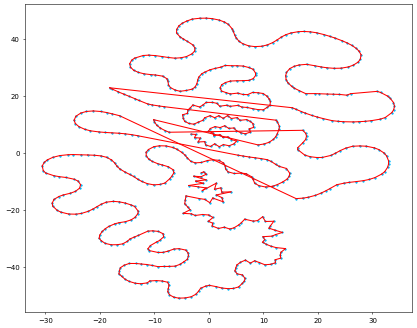

Perplexity: 60


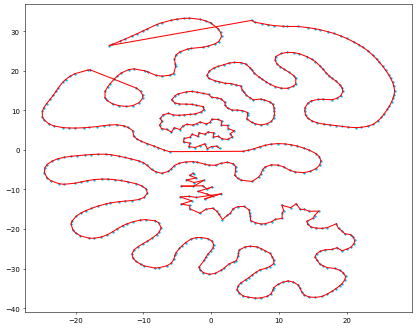

Perplexity: 75


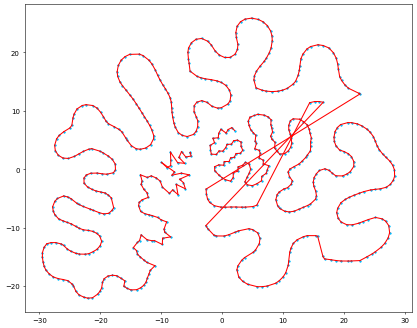

Perplexity: 90


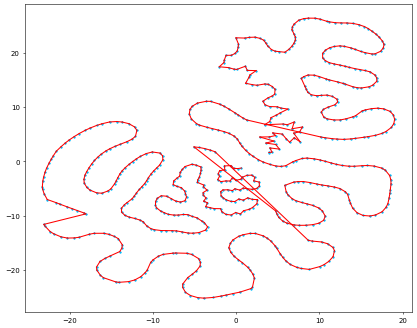

Perplexity: 105


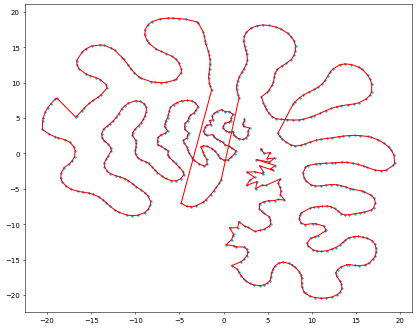

Perplexity: 120


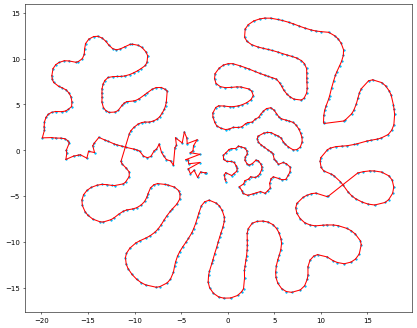

Perplexity: 135


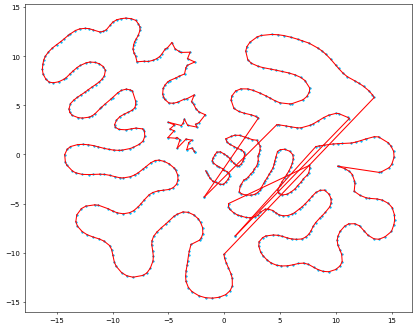

Perplexity: 150


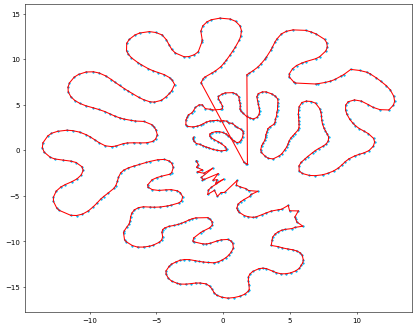

Perplexity: 165


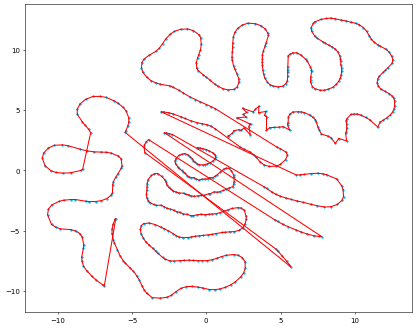

Perplexity: 180


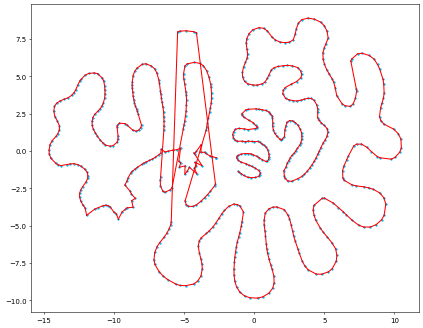

Perplexity: 195


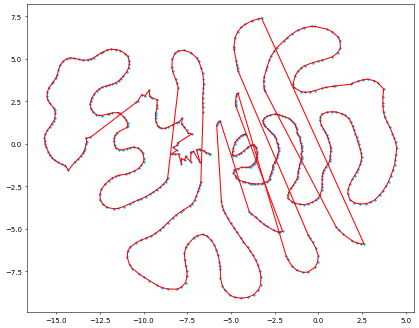

Perplexity: 210


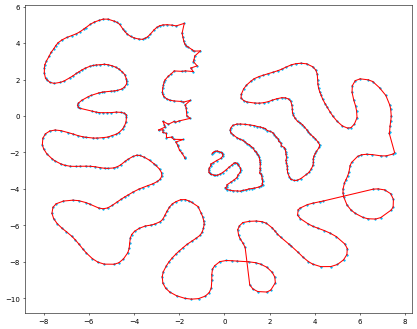

Perplexity: 225


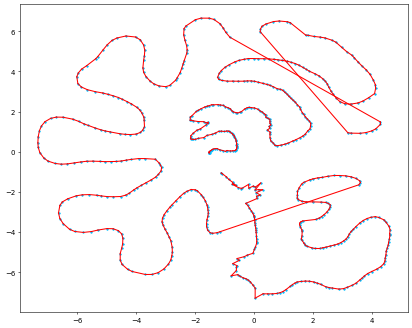

Perplexity: 240


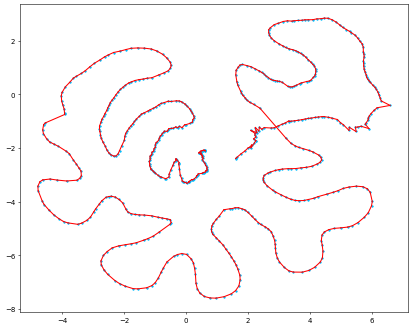

Perplexity: 255


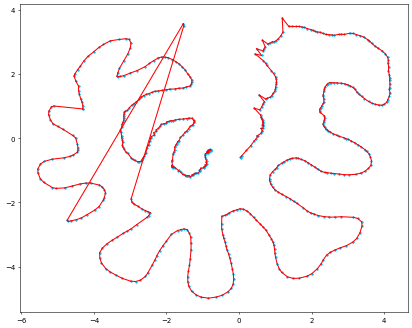

Perplexity: 270


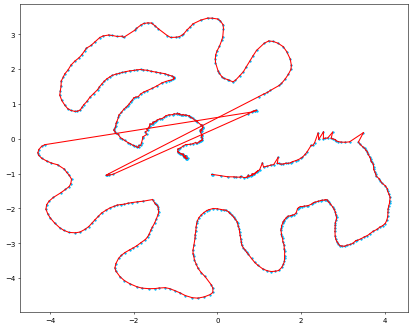

Perplexity: 285


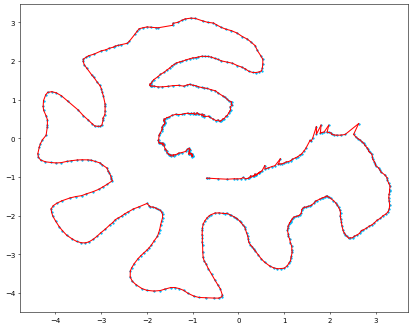

In [4]:
# compare tsne graphs with different perplexity range(15, 300, 15)
# perplexity_range = np.arange(15, 300, 15)
# for perplexity in perplexity_range:
#     old_stdout = sys.stderr
#     sys.stderr = StringIO()
#     tsne_results = compute_tsne(all_weights, perplexity=perplexity)
#     sys.stderr = old_stdout
#     # Plotting (connect centroids with lines)
#     plt.figure(figsize=(10, 8), dpi=50)
#     prev_center = None
#     print(f'Perplexity: {perplexity}')
#     for idx in range(len(model_paths)):
#         x = tsne_results[idx, 0]
#         y = tsne_results[idx, 1]
#         plt.scatter(x, y, s=5, color='deepskyblue')
#         if prev_center:
#             plt.plot([prev_center[0], x], [prev_center[1], y], color='red', alpha=1)
#         prev_center = [x, y]
#     plt.show(block=False)

In [14]:
tsne_results = compute_tsne(all_weights, perplexity=250, n_iter=3000)

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

In [15]:
# get the length between each centroid
lengths = []
angles = []
prev_angle = None
for idx in range(1, len(model_paths)):
    if idx != 1:
        lengths.append(np.linalg.norm(tsne_results[idx] - tsne_results[idx-1]))
    current_angle = np.arctan2(tsne_results[idx][1] - tsne_results[idx-1][1], tsne_results[idx][0] - tsne_results[idx-1][0])
    if prev_angle is not None:
        angles.append(abs(current_angle - prev_angle))
    prev_angle = current_angle

# normalize lengths and angles
lengths = np.array(lengths)
lengths = (lengths - np.min(lengths)) / (np.max(lengths) - np.min(lengths))
angles = np.array(angles)
angles = (angles - np.min(angles)) / (np.max(angles) - np.min(angles))
# compute score
length_weight = 0.8
angle_weight = 0.2

score = length_weight * lengths + angle_weight * angles
total_score = np.sum(score)

# select 50 models
num_selected = 50
target_score = total_score / num_selected
selected_models = []
current_score = 0
score_threshold = 0
# select every 10 selected models for rendering
double_selected = []
double_selected_count = 0
for idx in range(1, len(model_paths)-1):
    current_score += score[idx-1]
    if current_score >= score_threshold:
        selected_models.append(idx)
        if double_selected_count == 0:
            double_selected.append(idx)
            double_selected_count = 5
        double_selected_count -= 1
        score_threshold += target_score

In [16]:
len(double_selected)

11

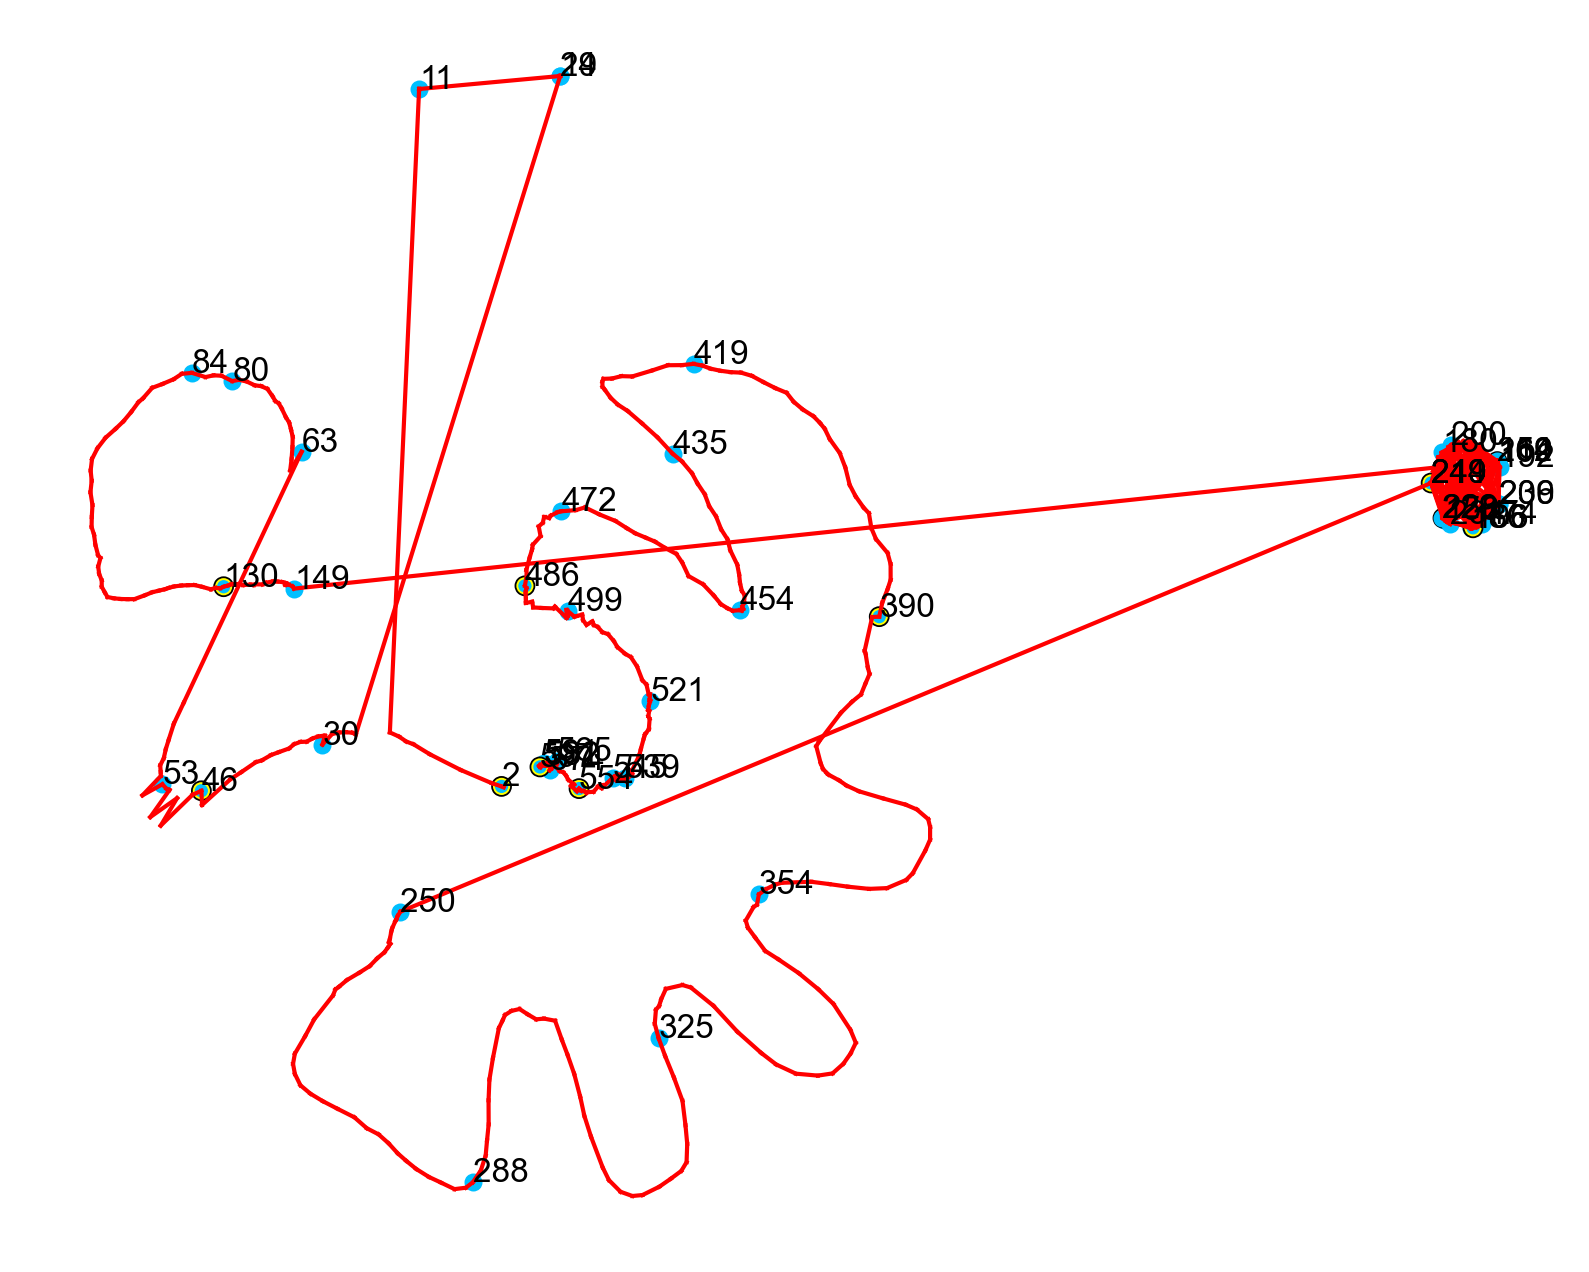

In [17]:
from matplotlib import patheffects

prev_center = []
# Plotting
plt.figure(figsize=(10, 8), dpi=200)

black = [0, 0, 0]
red = [1, 0, 0]

for idx in range(len(model_paths)):
    x = tsne_results[idx, 0]
    y = tsne_results[idx, 1]
    
    if idx in selected_models:
        if idx in double_selected:
            plt.scatter(x, y, s=30, color='deepskyblue', edgecolors='yellow', linewidths=0.7, path_effects=[
            patheffects.withStroke(linewidth=2, foreground="black") # <-- Black outline!
        ])
        else:
            plt.scatter(x, y, s=30, color='deepskyblue')
        plt.annotate(f'{idx+1}', (x, y), fontsize=12, fontfamily='Arial', color='black')
    
    # draw line to previous center
    if prev_center:
        # line
        plt.plot([prev_center[0], x], [prev_center[1], y], color=red, alpha=1)
    prev_center = [x, y]

    # Annotate the plot with the label at the centroid
    # if idx % 20 == 0:
    #     plt.annotate(f'Model {idx+1}', (centroid_x, centroid_y), fontsize=12)
    
# remove axis ticks
plt.xticks([])
plt.yticks([])
plt.axis('off')

# get current x and y limits
x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

# r = 0.1
# plt.xlim(x0 - r*(x1-x0), x1 + r*(x1-x0))
# plt.ylim(y0 - r*(y1-y0), y1 + r*(y1-y0))
plt.savefig('tsne.png')
plt.show(block=False)

In [64]:
print(double_selected)

ic| double_selected: [1, 18, 61, 111, 212, 296, 344, 388, 491, 548]


[1, 18, 61, 111, 212, 296, 344, 388, 491, 548]